tensor([[0.2025],
        [0.2030],
        [0.2034],
        ...,
        [1.0426],
        [1.0431],
        [1.0436]], grad_fn=<AddmmBackward0>)


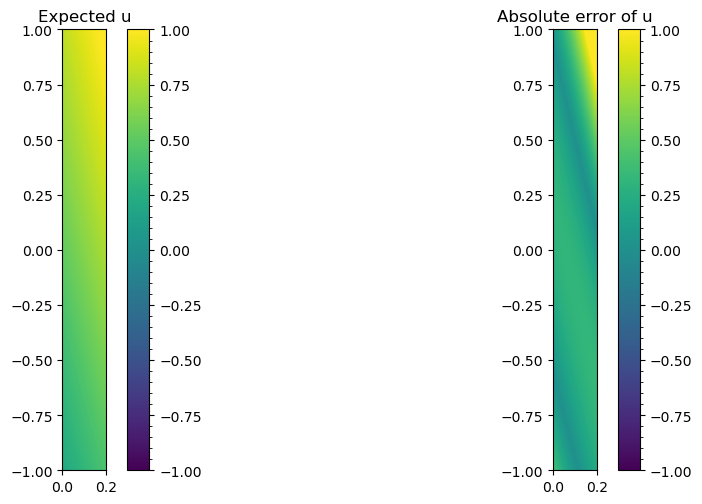

In [1]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

from Building_Net import Net
#from BM_WZ_CHnet import Initial_Condition_Loss, Initial_Condition_u

import os
from datetime import datetime
currentDateTime = datetime.now()
#print("Date of Today : ", currentDateTime.month, " /", currentDateTime.day, "\nHour : ", currentDateTime.hour) 

#Date of Today
ctime = f"{currentDateTime.month}_{currentDateTime.day}_{currentDateTime.hour}h"

net = Net() #.to(device)

net.load_state_dict(torch.load("lr0.001_t0.1_4_3_18h.pt")) #, map_location=torch.device('cpu')

#Graph at various time slices

spatial_discretization = 500


#Define numpy arrays for inputs
end_time = .2
x1 = np.linspace(0,end_time,spatial_discretization).reshape(spatial_discretization)
x2 = np.linspace(net.x1_l,net.x1_u,spatial_discretization).reshape(spatial_discretization)
x1x2 = np.array(np.meshgrid(x1, x2)).reshape(2,spatial_discretization**2)

x1_input = x1x2[0].reshape(spatial_discretization**2, 1)
x2_input = x1x2[1].reshape(spatial_discretization**2, 1)

x1x2 = [x1_input, x2_input]

#convert to pytorch tensors
pt_x1 = Variable(torch.from_numpy(x1_input).float(), requires_grad=True) #.to(device)
pt_x2 = Variable(torch.from_numpy(x2_input).float(), requires_grad=True) #.to(device)

#get network outputs
u = net(pt_x2, pt_x1)
print(u)
#u = u.data.cpu().numpy()

u_t = torch.autograd.grad(u.sum(), pt_x1, create_graph=True)[0]  
        
u_x = torch.autograd.grad(u.sum(), pt_x2, create_graph=True)[0]
u_xx = torch.autograd.grad(u_x.sum(), pt_x2, create_graph=True)[0]
        
        
u_ab_err  = torch.abs(u_t - .0001*u_xx + 4*u**3 -4*u) #((((phi_pred1 - phi)**2)**.5))
u_ab_err = u_ab_err.data.cpu().numpy()

#phi_ab_err2  = phi_pred2 - phi_pred1 #((((phi_pred2 - phi_pred1)**2)**.5))
#phi_ab_err3  = phi_pred3 - phi_pred2 #((((phi_pred3 - phi_pred2)**2)**.5))

X, Y = np.meshgrid(x1, x2)



fig, axs = plt.subplots(1,2, figsize=(8,5) )
#fig.suptitle(f'Time = {time_plotted}')
fig.tight_layout()
axs[0].set_title('Expected u')
axs[1].set_title('Absolute error of u')

## Graph1 #################################################################################################

# Plot both positive and negative values between +/- 1.2
mapping = axs[0].imshow(u.data.cpu().numpy().reshape(X.shape), vmin=-1 , vmax=1 ,
                             interpolation='none', extent = (0,end_time, net.x1_u, net.x1_l)) #, cmap='pink_r',extentfloats (left, right, bottom, top), optional
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(mapping, ax=axs[0].invert_yaxis()) #, extend='both'
cbar.minorticks_on()


## Graph2 #################################################################################################

# Plot both positive and negative values between +/- 1.2
mapping = axs[1].imshow(u_ab_err.reshape(X.shape), vmin=-1 , vmax=1 ,
                             interpolation='none', extent = (0,end_time, net.x1_u, net.x1_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(mapping, ax=axs[1].invert_yaxis())
cbar.minorticks_on()

fig.set_figheight(5)
fig.set_figwidth(10)

plt.show()

fig.savefig(f"fig_{ctime}.png")

#Printing on Wide Screen                    
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [8]:
for name, param in net.state_dict().items():
    print(f"{name}: {param.shape}")
    print(param)

hidden_layer_u1.0.weight: torch.Size([128, 2])
tensor([[ 1.6795e-03, -6.2917e-02],
        [-7.6007e-04,  9.3822e-02],
        [ 5.1561e-03, -5.4633e-02],
        [ 4.9702e-03,  3.3564e-02],
        [-5.0053e-03,  4.0970e-04],
        [ 9.1287e-03,  2.6910e-01],
        [-2.7727e-03, -2.0016e-02],
        [-4.3417e-03, -1.4062e-01],
        [ 3.1517e-03,  7.0351e-02],
        [-1.7011e-03, -4.5130e-03],
        [-3.7749e-03, -4.7297e-03],
        [ 1.5658e-03,  1.7711e-01],
        [-7.3819e-04,  9.1029e-02],
        [-3.1683e-03, -3.0519e-02],
        [ 8.1857e-04,  3.4478e-03],
        [-4.8327e-04,  2.5849e-03],
        [ 1.1687e-02, -1.6957e-02],
        [ 3.0492e-03,  1.5391e-01],
        [-7.2478e-04,  6.8517e-03],
        [ 8.4822e-04, -5.6461e-03],
        [-8.0177e-03, -2.5080e-01],
        [-4.2651e-04,  7.7752e-03],
        [ 1.3462e-03,  4.7708e-03],
        [-4.5751e-03, -3.0451e-02],
        [ 1.1032e-02,  1.3495e-01],
        [ 3.0363e-03,  1.0964e-01],
        [ 8.3936e

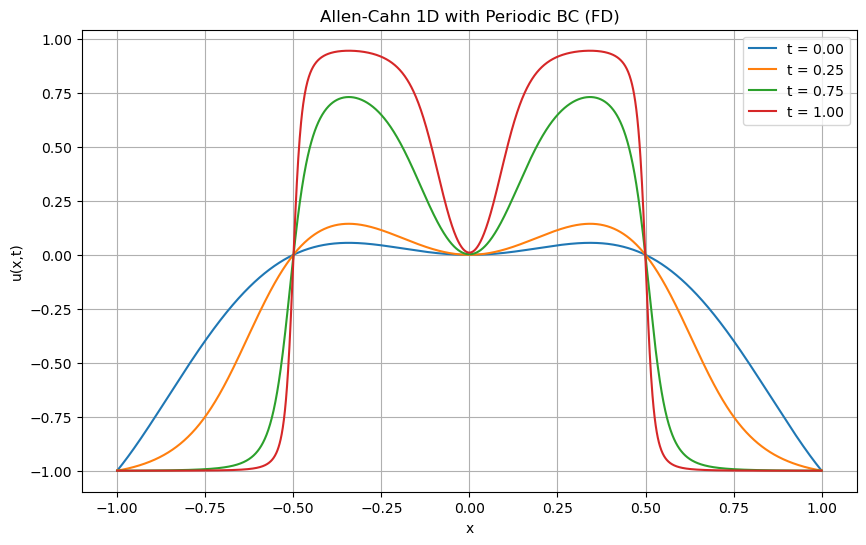

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#We will process FD for u on 2-dim domain of (x,t)

#to collect u point at (x,0), define dx and input variable x
dx = 0.001
Lx = 1- (-1)
Nx = int(Lx/dx)
x = np.linspace(-1, 1,Nx)# 1 contained?

#defind u by initial condition of u at t=0
u = x**2 * np.sin(2 *np.pi * x)


#defind boundary condition of u for every points of u
def BoundaryCondition(u):
    u[0] = u[-1]
    u[1] = u[-2]
    return u

#to collect u points at (const, t) for each point x = const based on above initialized u,
#define dt and input variable t
dt = 1e-4
T = 1

#To express the governing equation, define the function for u_xx. Here we use central difference approximation.
def u_xx(x, u):
    u_xx = (np.roll(u,-1) -2 * u + np.roll(u,1))/dx**2
    return u_xx
u_list = [u.copy()]
# as time increases, collect u points by updating new u at next time step
for n in list(range(int(T/dt)-2)):
    u = u + dt * (.0001*u_xx(x, u) - 4 * u**3 + 4*u)
    u = BoundaryCondition(u)
    if n %100 == 0:
        u_list.append(u.copy())
# Plot u(x,t) at selected times
sample_times = [0.0, 0.25, 0.75, 1.0]
sample_indices = [int(t / dt / 100) for t in sample_times]

plt.figure(figsize=(10, 6))
for idx, t in zip(sample_indices, sample_times):
    plt.plot(x, u_list[idx], label=f't = {t:.2f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Allen-Cahn 1D with Periodic BC (FD)')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/j9/4s8713nn53v3jz3ky1rz1f6h0000gn/T/ipykernel_8464/3568830053.py:100: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


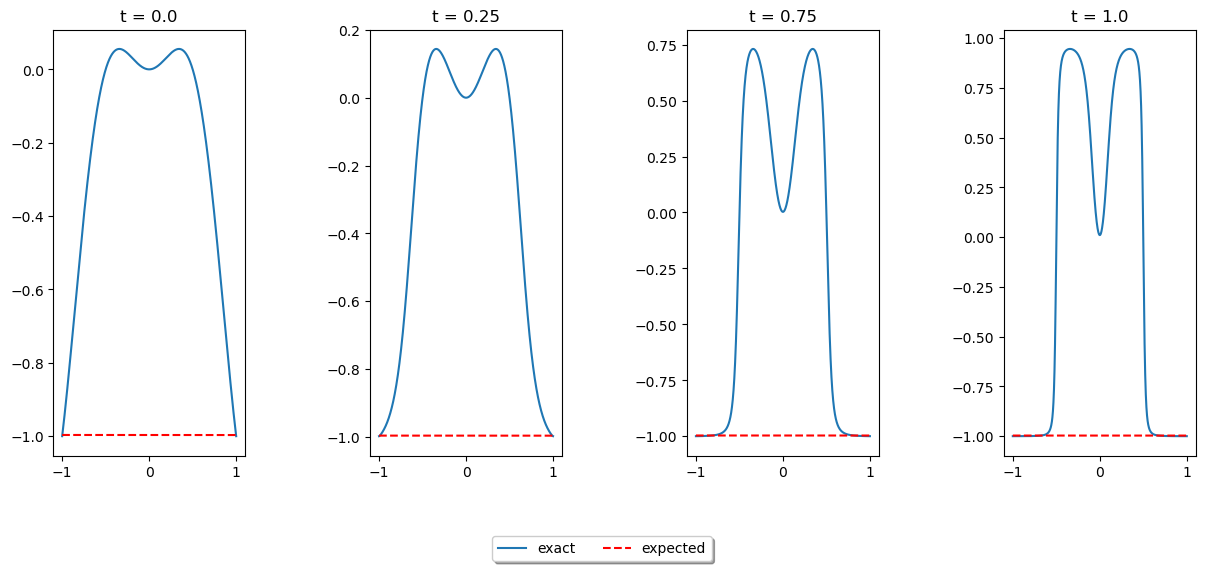

<Figure size 1000x600 with 0 Axes>

In [4]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

from Building_Net import Net
#from BM_WZ_CHnet import Initial_Condition_Loss, Initial_Condition_u

import os
from datetime import datetime
currentDateTime = datetime.now()
#print("Date of Today : ", currentDateTime.month, " /", currentDateTime.day, "\nHour : ", currentDateTime.hour) 

#Date of Today
ctime = f"{currentDateTime.month}_{currentDateTime.day}_{currentDateTime.hour}h"


net = Net() #.to(device)

net.load_state_dict(torch.load("lr0.001_t1_4_3_10h.pt"))

#Graph at various time slices

spatial_discretization = 2000


#Define numpy arrays for inputs
end_time = 1
x1 = np.linspace(0,end_time,spatial_discretization).reshape((spatial_discretization,1))
#x2 = np.linspace(net.x1_l,net.x1_u,spatial_discretization).reshape(spatial_discretization)

t1 = 0*np.ones((spatial_discretization,1))
t2 = 0.25*np.ones((spatial_discretization,1))
t3 = 0.75*np.ones((spatial_discretization,1))
t4 = end_time*np.ones((spatial_discretization,1))

#convert to pytorch tensors
pt_x1 = Variable(torch.from_numpy(x1).float(), requires_grad=True) #.to(device)
#pt_x2 = Variable(torch.from_numpy(x2).float(), requires_grad=True) #.to(device)

pt_t1 = Variable(torch.from_numpy(t1).float(), requires_grad=True) #.to(device)
pt_t2 = Variable(torch.from_numpy(t2).float(), requires_grad=True) #.to(device)
pt_t3 = Variable(torch.from_numpy(t3).float(), requires_grad=True) #.to(device)
pt_t4 = Variable(torch.from_numpy(t4).float(), requires_grad=True) #.to(device)

#get network outputs
u1 = net(pt_x1,pt_t1)
u2 = net(pt_x1,pt_t2)
u3 = net(pt_x1,pt_t3)
u4 = net(pt_x1,pt_t4)
#u = u.data.cpu().numpy()

#phi_pred2, _ = net(pt_x1, pt_x2, pt_t2)
#phi_pred2 = phi_pred2.data.cpu().numpy()

#phi_pred3, _ = net(pt_x1, pt_x2, pt_t3)
#phi_pred3 = phi_pred3.data.cpu().numpy()

#get actual initial condition
#u_exact = Initial_Condition_u(net, pt_x1, pt_x2)
#P_exact = net.P_eq(pt_x1, pt_x2, pt_x3, pt_t)

#Convert back to numpy
#u = u_exact.data.cpu().numpy()

u1_t = torch.autograd.grad(u1.sum(), pt_t1, create_graph=True)[0]  
u1_x = torch.autograd.grad(u1.sum(), pt_x1, create_graph=True)[0]
u1_xx = torch.autograd.grad(u1_x.sum(), pt_x1, create_graph=True)[0]

u2_t = torch.autograd.grad(u2.sum(), pt_t2, create_graph=True)[0]  
u2_x = torch.autograd.grad(u2.sum(), pt_x1, create_graph=True)[0]
u2_xx = torch.autograd.grad(u2_x.sum(), pt_x1, create_graph=True)[0]

u3_t = torch.autograd.grad(u3.sum(), pt_t3, create_graph=True)[0]  
u3_x = torch.autograd.grad(u3.sum(), pt_x1, create_graph=True)[0]
u3_xx = torch.autograd.grad(u3_x.sum(), pt_x1, create_graph=True)[0]

u4_t = torch.autograd.grad(u4.sum(), pt_t4, create_graph=True)[0]  
u4_x = torch.autograd.grad(u4.sum(), pt_x1, create_graph=True)[0]
u4_xx = torch.autograd.grad(u4_x.sum(), pt_x1, create_graph=True)[0]
        
        
u1_ab_err  = torch.abs(u1_t - .0001*u1_xx + 4*u1**3 -4*u1) #((((phi_pred1 - phi)**2)**.5))
u1_ab_err = u1_ab_err.data.cpu().numpy()

u2_ab_err  = torch.abs(u2_t - .0001*u2_xx + 4*u2**3 -4*u2) #((((phi_pred1 - phi)**2)**.5))
u2_ab_err = u2_ab_err.data.cpu().numpy()

u3_ab_err  = torch.abs(u3_t - .0001*u3_xx + 4*u3**3 -4*u3) #((((phi_pred1 - phi)**2)**.5))
u3_ab_err = u3_ab_err.data.cpu().numpy()

u4_ab_err  = torch.abs(u4_t - .0001*u4_xx + 4*u4**3 -4*u4) #((((phi_pred1 - phi)**2)**.5))
u4_ab_err = u4_ab_err.data.cpu().numpy()

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(6, 4),
                        layout="constrained")
#fig, axs = plt.subplots(1,4, figsize=(6,4) )
#fig.suptitle(f'Time = {time_plotted}')
fig.tight_layout()
axs[0].set_title('t = 0.0')
axs[1].set_title('t = 0.25')
axs[2].set_title('t = 0.75')
axs[3].set_title('t = 1.0')

# evenly sampled time at 200ms intervals
x = np.arange(-1, 1, 2/spatial_discretization)

# Plot u(x,t) at selected times
sample_times = [0.0, 0.25, 0.75, 1.0]
sample_indices = [int(t / dt / 100) for t in sample_times]

plt.figure(figsize=(10, 6))
i = 0
for idx, t in zip(sample_indices, sample_times):
    if i == 0:
        axs[i].plot(x, u_list[idx], label = 'exact')
    else:
        axs[i].plot(x, u_list[idx])
    i +=1

# red dashes, blue squares and green triangles
l1 = axs[0].plot(x, u1.data.cpu().numpy(),'r--',label = 'expected' )
#l2 = axs[0].plot( x, u1_ab_err,label = 'expected2')

axs[1].plot(x, u2.data.cpu().numpy(), 'r--')
axs[2].plot(x, u3.data.cpu().numpy(), 'r--')
axs[3].plot(x, u4.data.cpu().numpy(), 'r--')
#plt.show()
###
fig.set_figheight(5)
fig.set_figwidth(13)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

fig.savefig(f"fig_{ctime}.png")

#Printing on Wide Screen                    
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
